In [1]:
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import sqlite3
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
import sys

# Liste des fonctions

## f_requete_sql - Requete SQL

In [2]:
def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('../data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

## f_clusters_transform - Fonction conversion df en np.array

In [3]:
def f_clusters_transform (df):
    """
    df : dataframe pandas
    """
    data = df.values.T
    names = df.columns
    return(data, names)

## f_clusters_coude - Fonction d'affichage de l'inertie en fonction du nombre de clusters

In [4]:
def f_clusters_coude (df, k_max:int=15):
    """
    k_max : entier représentant le nombre max de clusters à tracer
    """
    data, names = f_clusters_transform(df)
    Sum_of_squared_distances = [] 
    K = range(1,k_max) 
    for k in K : 
        print(f"Calcul pour {k} clusters.")
        km = TimeSeriesKMeans(n_clusters=k) 
        km = km.fit(data) 
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-') 
    plt.xlabel('k') 
    plt.ylabel('Sum_of_squared_distances') 
    plt.title('Méthode du coude pour k optimal') 
    plt.show()


## f_clusters_fit - Fonction entrainement du modèle, retour des labels et profils clusters

In [5]:
def f_clusters_fit (df, k:int = 4, n_init:int = 100, max_iter:int = 2000, metric:str = "euclidean"):
    
    """
    Entrainement et affichage de la distribution dans les clusters
    return :
    - cluster_table : df bss - cluster - MSE
    - df_clusters_centers : df série temporelle des clusters
    - metric : "euclidean" / "dtw" / "softdtw"
    """
    
    data, names = f_clusters_transform(df)
    # Initilialisation du modèle
    km = TimeSeriesKMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, metric=metric, random_state=2022)
    # Entraînement du modèle
    km.fit(data)
    print("Entrainement du modèle")
    # Définition des numéros de cluster
    labels = km.labels_+1
    # Profils des clusters
    print("Création des profils des clusters")
    cluster_centers = np.array(km.cluster_centers_[:,:,0])
    df_cluster_centers = pd.DataFrame(cluster_centers.T, index=df.index)
    for cluster in range(df_cluster_centers.shape[1]):
        df_cluster_centers.rename(columns = {cluster:f"cluster_{cluster+1}"}, inplace=True)
    
    # Création du dataframe de résultats
    print("Création du dataframe de résultat")
    cluster_table = pd.DataFrame()
    cluster_table["code_bss"] = names
    cluster_table.set_index("code_bss", inplace=True)
    cluster_table["cluster"] = labels
    for piezo in cluster_table.index :
        cluster_table.loc[piezo, "MSE"] = mean_squared_error(df.loc[:,piezo], cluster_centers[cluster_table.loc[piezo, "cluster"]-1])
    
    return cluster_table, df_cluster_centers

## f_plot_clusters - Fonction d'affichage des chroniques par cluster

In [6]:
def f_plot_clusters (df, cluster_table, cluster_centers, plot_mean:bool = True):
    
    data, names = f_clusters_transform (df)
    
    labels = cluster_table["cluster"]
    
    fig, axs = plt.subplots(len(set(labels)),1,figsize=(20,25))
    row_i=0

    for label in set(labels):
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i].plot(df.iloc[:,i],alpha=0.4)
        if plot_mean:
            axs[row_i].plot(cluster_centers.iloc[:,label-1],c="red")
        axs[row_i].set_title("Cluster "+str(row_i+1))
        row_i+=1
    plt.show()

## f_plot_all - Fonction d'affichage individuel des chroniques et leur cluster associé

In [7]:
def f_plot_all (df, cluster_table, df_cluster_centers) :

    if df.shape[1]%4 == 0:
        nbre_lignes = df.shape[1]//4
    else : 
        nbre_lignes = df.shape[1]//4 + 1

    fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
    #fig.suptitle('Series')
    for i in range(nbre_lignes):
        for j in range(4):
            if i*4+j+1>df.shape[1]: # pass the others that we can't fill
                continue
            axs[i, j].plot(df.iloc[:,i*4+j])
            axs[i, j].plot(df_cluster_centers.iloc[:,cluster_table.iloc[i*4+j,0]-1])
            
            axs[i, j].set_title(df.columns[i*4+j] + f" - MSE = {round(cluster_table.loc[df.columns[i*4+j],'MSE'],2)}")
            
    plt.show()

## f_MSEmin - Fonction de calcul du seuil minimal MSE

In [8]:
def f_MSEmin (cluster_table):
    # Calcul de MSEmin

    Q1 = cluster_table["MSE"].quantile(0.25, "higher")
    Q3 = cluster_table["MSE"].quantile(0.75, "lower")

    # Ecart inter-quartile
    IQM = abs(Q3-Q1)

    # Seuil minimal de conservation des chroniques (Q3+1.5*IQM)

    MSEmin = Q3+1.5*IQM
    return MSEmin

# Exploitation - 1ère passe

## Chargement des données

Les données sont récoltées à partir des csv créés lors du nettoyage et la sélection des piezos avec le moins de données manquantes et la plus longue plage de temps possible.

In [9]:
region = "GES"

# Import du csv et conversion en dataframe
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
data = pd.read_csv(f"./data/{region}.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)

print(f"Il y a {data.shape[1]} piezos pour le clustering dans le dataframe.")

Il y a 186 piezos pour le clustering dans le dataframe.


## Analyse du nombre optimal de clusters

Calcul pour 1 clusters.
Calcul pour 2 clusters.
Calcul pour 3 clusters.
Calcul pour 4 clusters.
Calcul pour 5 clusters.
Calcul pour 6 clusters.
Calcul pour 7 clusters.
Calcul pour 8 clusters.
Calcul pour 9 clusters.
Calcul pour 10 clusters.
Calcul pour 11 clusters.
Calcul pour 12 clusters.
Calcul pour 13 clusters.
Calcul pour 14 clusters.
Calcul pour 15 clusters.
Calcul pour 16 clusters.
Calcul pour 17 clusters.
Calcul pour 18 clusters.
Calcul pour 19 clusters.


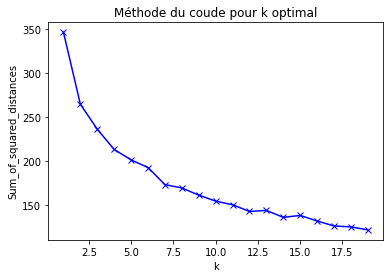

In [10]:
f_clusters_coude(data, 20)

## Création des clusters

In [11]:
# Choix du nombre de clusters à créer
nbre_clusters = 8

Entrainement du modèle
Création des profils des clusters
Création du dataframe de résultat


C:\Users\daranlot\Anaconda3\envs\Environnement\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


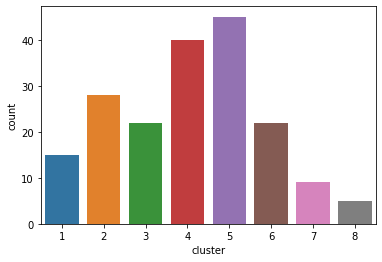

In [12]:
# Entrainement
cluster_table, cluster_centers = f_clusters_fit(data, nbre_clusters)

# répartition des piezos dans les clusters
sns.countplot(cluster_table.cluster)
# On renomme les noms de cluster par rapport à la région
for index, column in enumerate (cluster_centers.columns):
    cluster_centers.rename(columns={column : f"{region}_{index+1}"}, inplace=True)

In [13]:
cluster_table.head()

,cluster,MSE
code_bss,,
03423X0056_100,4,0.155617
02706X0074_S77-20,2,0.446492
04137X0009_C20,3,0.236367
04133X0006_30,3,0.154754
03786X0074_130,2,0.098200


In [14]:
cluster_centers.head()

,GES_1,GES_2,GES_3,GES_4,GES_5,GES_6,GES_7,GES_8
date_mesure,,,,,,,,
2005-03-17,-1.592813,-0.404047,-1.258390,-0.073027,0.401875,-0.644179,-0.939749,0.370333
2005-03-24,-1.513089,-0.405951,-1.313607,-0.022513,0.317580,-0.596989,-0.516825,0.346257
2005-03-31,-1.540578,-0.437574,-1.367091,-0.053668,0.216038,-0.609493,-0.426984,0.310410
2005-04-07,-1.461139,-0.401620,-1.416084,0.187529,0.225820,-0.488493,0.050016,0.363496
2005-04-14,-1.143497,-0.357741,-1.421016,0.597130,0.232858,-0.444145,0.334436,0.441588


## Affichage des clusters

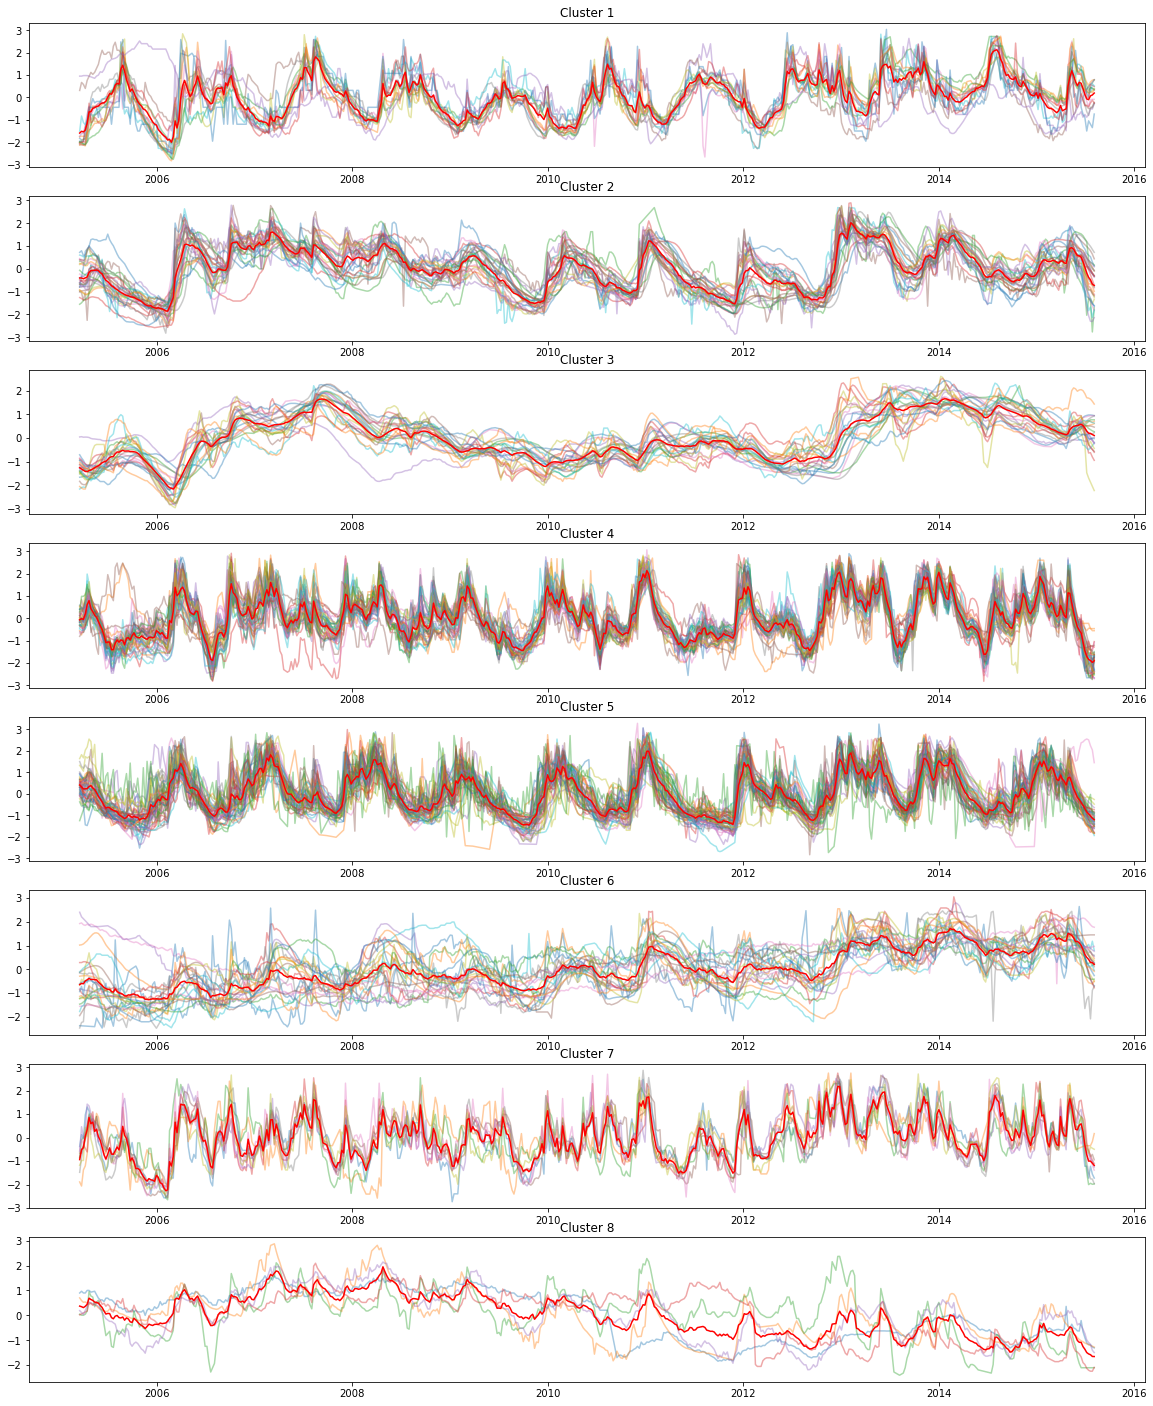

In [15]:
f_plot_clusters(data, cluster_table, cluster_centers)

In [16]:
#f_plot_all(data, cluster_table, cluster_centers)

In [17]:
cluster_table.groupby("cluster").mean()

,MSE
cluster,
1,0.359395
2,0.273990
3,0.230737
4,0.246018
5,0.306711
6,0.451247
7,0.282178
8,0.368941


## Filtre des chroniques avec score insuffisant

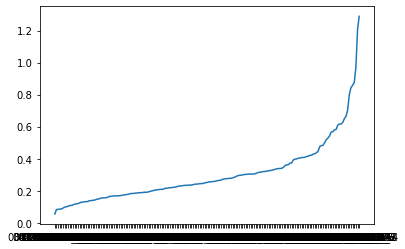

In [18]:
plt.plot(cluster_table["MSE"].sort_values())

Entrainement du modèle
Création des profils des clusters
Création du dataframe de résultat
Itération 1 : 0 chronique(s) éliminée(s).
Nombre de chroniques éliminées : 0


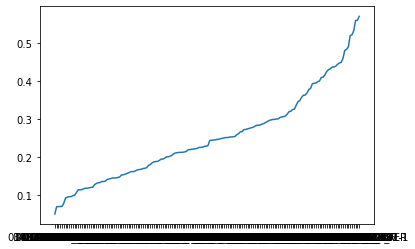

In [19]:
# nbre de chroniques sous le seuil
MSEmin = f_MSEmin(cluster_table)
nbre_elim = cluster_table.loc[cluster_table.MSE > MSEmin, 'MSE'].count()
iteration = 1
nbre_elim_total = 0

while nbre_elim != 0 :
    # chroniques sous le seuil passées à cluster 0
    MSEmin = f_MSEmin(cluster_table)
    cluster_table.loc[cluster_table.MSE > MSEmin, "cluster"] = 0
    
    # Selection des clusters non zéro
    data = data.loc[:,cluster_table.loc[cluster_table.cluster != 0].index]
    
    # Nouveau clustering
    cluster_table, cluster_centers = f_clusters_fit(data, nbre_clusters)
    
    nbre_elim = cluster_table.loc[cluster_table.MSE > MSEmin, 'MSE'].count()
    
    print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")
    iteration += 1
    
    nbre_elim_total += nbre_elim
    
for index, column in enumerate (cluster_centers.columns):
    cluster_centers.rename(columns={column : f"{region}_{index+1}"}, inplace=True)    
    
print(f"Nombre de chroniques éliminées : {nbre_elim_total}")
    
plt.plot(cluster_table["MSE"].sort_values())

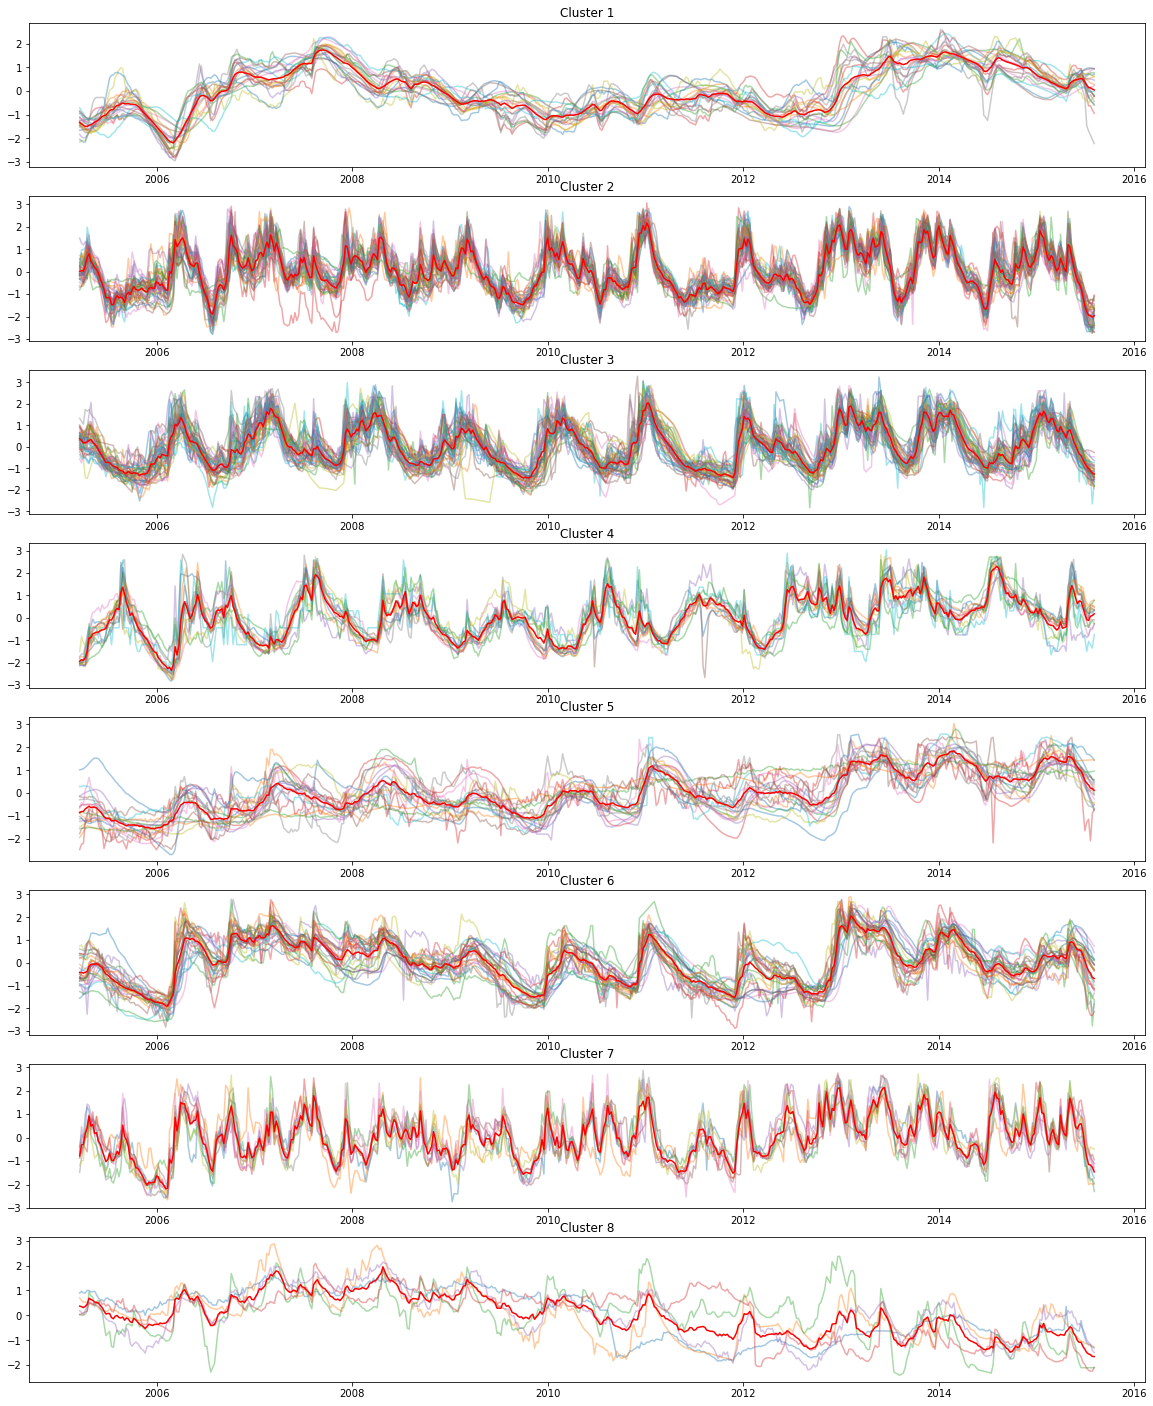

In [20]:
f_plot_clusters(data, cluster_table, cluster_centers)

In [21]:
cluster_table.sort_values(by='MSE')

,cluster,MSE
code_bss,,
03787X0071_121A,1,0.049605
04133X0033_40B,1,0.068896
04133X0029_32A,1,0.069028
04133X0030_40A,1,0.069144
03427X0027_92,2,0.069545
...,...,...
01322X0049_PZADER,3,0.521672
03426X0254_137,5,0.532548
02343X0003_561,5,0.559241


In [22]:
cluster_table.groupby("cluster").mean()

,MSE
cluster,
1,0.201649
2,0.210109
3,0.258462
4,0.244517
5,0.327023
6,0.265037
7,0.243809
8,0.368941


# Ajout à la bdd

In [23]:
# Nom de la table
table = "cluster_kmeans"

In [24]:
# Création de la table
requete = f"""
                    ALTER TABLE data_piezo
                    ADD {table} VARCHAR(6) DEFAULT NULL
                    """
f_requete_sql(requete)

Connexion réussie à SQLite
Connexion SQLite est fermée


[]

In [33]:
# Création de listes de nuéro de cluster avec le nom des piezos
# Ajout dans la bdd
for label in set(cluster_table.cluster):
    cluster = tuple(cluster_table.loc[cluster_table.cluster == label, 'cluster'].index.to_list())
    requete = f"""
        UPDATE data_piezo
        SET {table} = '{label}'
        WHERE code_bss IN {cluster}
        """
    f_requete_sql(requete)

Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée


## Suppresion colonne

requete = """
                    ALTER TABLE data_piezo
                    DROP cluster_kmeans_ALL
                    """
f_requete_sql(requete)